In [13]:
# Importing the necessary packages
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split


### Data Preprocessing and Visualization

In [14]:

# Read names from files
with open('/content/drive/MyDrive/Gender_Classification_by_Names/Data/sorted males.txt', 'r') as file:
    male_names = file.read().splitlines()

with open('/content/drive/MyDrive/Gender_Classification_by_Names/Data/sorted females.txt', 'r') as file:
    female_names = file.read().splitlines()

# Create DataFrame
male_df = pd.DataFrame({'name': male_names, 'gender': 'M'})
female_df = pd.DataFrame({'name': female_names, 'gender': 'F'})

# Combine the DataFrames
df = pd.concat([male_df, female_df], ignore_index=True)


In [15]:
df.sample(10)

,name,gender
5001,Thin Thin Myint,F
4336,Ngwe Yin,F
527,Hla Maung Thein,M
2797,Win Min,M
2572,Tin Maung Soe,M
1839,Po,M
2336,Thar Oo,M
2481,Thet Win Hlaing,M
4793,Than Kyin,F
3441,Khin Khin Htar,F


In [5]:
df.dtypes

name      object
gender    object
dtype: object

In [6]:
df.size

10662

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5331 entries, 0 to 5330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5331 non-null   object
 1   gender  5331 non-null   object
dtypes: object(2)
memory usage: 83.4+ KB


In [8]:
df.isnull().sum()

name      0
gender    0
dtype: int64

In [9]:
df.sample(3)

,name,gender
2948,Zaw Moe,M
1666,Nyan Wai,M
2379,Thaung Tun,M


In [10]:
df[df.gender=='M'].describe()

,name,gender
count,3023,3023
unique,3023,1
top,Zin Thaung,M
freq,1,3023


In [11]:
df[df.gender=='F'].describe()

,name,gender
count,2308,2308
unique,2308,1
top,Zin Mar Win,F
freq,1,2308


In [20]:
df_names = df

In [13]:
print("Male : " + str(sum(df_names.gender=='M')))
print("Female : " + str(sum(df_names.gender=='F')))

Male : 3023
Female : 2308


In [14]:
df_names.sample(5)

,name,gender
239,Aung Win Tun,M
3431,Khin Htwe,F
293,Aye Saung,M
1554,Myo Oo,M
3808,Khin Yu Wai,F


In [25]:
df_names["name"] = df_names["name"].apply(lambda x : x.lower())

In [16]:
df_names.sample(3)

,name,gender
2301,than zaw oo,M
1840,po ni,M
2334,thar nyein,M


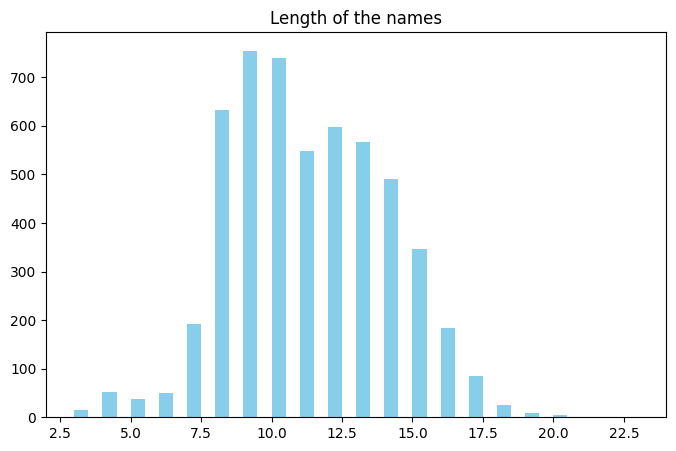

In [26]:
names = df_names["name"]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist([len(a) for a in names], bins=40 ,color='skyblue')
plt.title("Length of the names")
plt.show()



In [27]:
maxlen = 25

In [28]:
vocab = set(''.join(str(i) for i in names) )
vocab.add('EOW')  # EOW = end of word

for j in vocab:
    print(j)

a
h
g
l
s
b
k
r
w
y
e
p
z
t
u
j
o
n
c
d
EOW
 
m
i


In [29]:
vocab_size = len(vocab)
print(vocab_size)

24


In [30]:
char_index = dict((c, i) for i, c in enumerate(vocab))
char_index

{'a': 0,
 'h': 1,
 'g': 2,
 'l': 3,
 's': 4,
 'b': 5,
 'k': 6,
 'r': 7,
 'w': 8,
 'y': 9,
 'e': 10,
 'p': 11,
 'z': 12,
 't': 13,
 'u': 14,
 'j': 15,
 'o': 16,
 'n': 17,
 'c': 18,
 'd': 19,
 'EOW': 20,
 ' ': 21,
 'm': 22,
 'i': 23}

In [31]:
X = []
y = []
def set_encode(i):
  temp= np.zeros(vocab_size)
  temp[i] = 1
  return list(temp)

def preprocess_X(name):
  new_list = []

  train_name = [str(i)[0:maxlen]for i in name]

  for i in train_name:
        tmp = [set_encode(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_encode(char_index["EOW"]))
        new_list.append(tmp)
  return new_list

def preprocess_Y(y):
    new_list = []
    for i in y:
        if i == 'M':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list
X = preprocess_X(names.values)
y = preprocess_Y(df["gender"].values)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

### Model Building


In [24]:
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), backward_layer=LSTM(256, return_sequences=True, go_backwards=True), input_shape=(maxlen,vocab_size)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.2))
model.add(Dense(2, activity_regularizer=l2(0.002)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 25, 512)           575488    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 25, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
 activation (Activation)     (None, 2)                 0

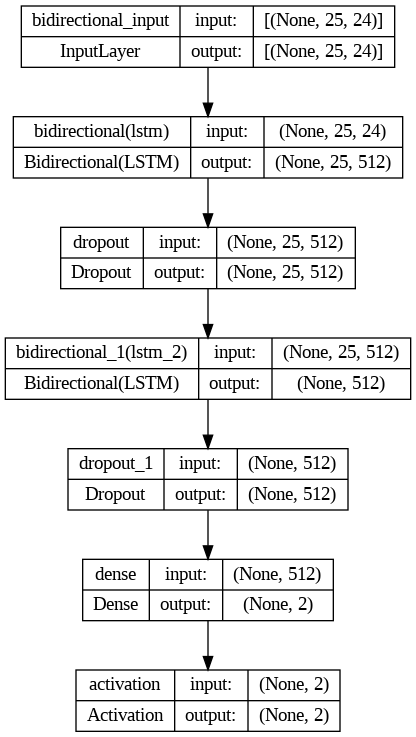

In [26]:
plot_model(model, to_file='/content/drive/MyDrive/Gender_Classification_by_Names/model.png', show_shapes=True, expand_nested=True)

In [27]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/Gender_Classification_by_Names/best_model.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')
batch_size = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=30, verbose=1, validation_data =(X_test, y_test), callbacks= [callback, mc, reduce_lr_acc])

Epoch 1/30
425/427 [============================>.] - ETA: 0s - loss: 0.5380 - accuracy: 0.7193
Epoch 1: saving model to /content/drive/MyDrive/Gender_Classification_by_Names/best_model.h5
427/427 [==============================] - 21s 27ms/step - loss: 0.5380 - accuracy: 0.7195 - val_loss: 0.5025 - val_accuracy: 0.7535 - lr: 0.0010
Epoch 2/30
  1/427 [..............................] - ETA: 6s - loss: 0.3801 - accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


424/427 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.7866
Epoch 2: saving model to /content/drive/MyDrive/Gender_Classification_by_Names/best_model.h5
427/427 [==============================] - 6s 13ms/step - loss: 0.4400 - accuracy: 0.7866 - val_loss: 0.4130 - val_accuracy: 0.8051 - lr: 0.0010
Epoch 3/30
424/427 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8132
Epoch 3: saving model to /content/drive/MyDrive/Gender_Classification_by_Names/best_model.h5
427/427 [==============================] - 10s 24ms/step - loss: 0.3972 - accuracy: 0.8138 - val_loss: 0.3648 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 4/30
423/427 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.8272
Epoch 4: saving model to /content/drive/MyDrive/Gender_Classification_by_Names/best_model.h5
427/427 [==============================] - 6s 14ms/step - loss: 0.3704 - accuracy: 0.8274 - val_loss: 0.3726 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 5/

<ipython-input-28-db6a12155480>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-28-db6a12155480>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

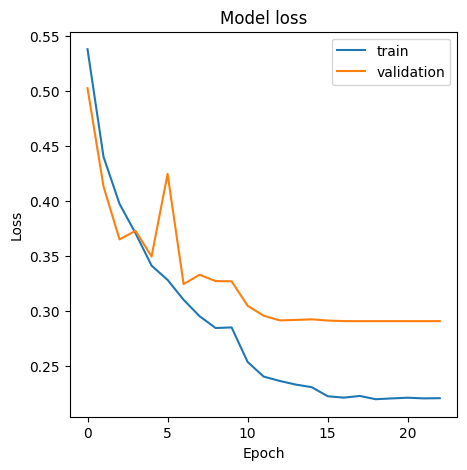

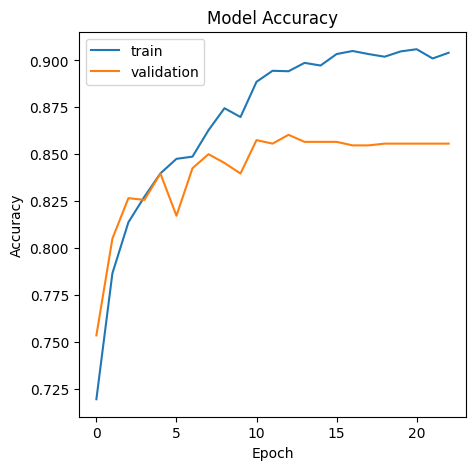

In [28]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(5,5)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(5,5)).set(xlabel='Epoch',ylabel='Accuracy')


In [29]:
y_predict = model.predict(X_test)

34/34 [==============================] - 2s 7ms/step


### Prediction with new data

In [10]:
def preprocess_single_name(name, char_index, vocab_size, maxlen):
    name = name.lower()
    def set_encode(i):
        temp = np.zeros(vocab_size)
        temp[i] = 1
        return list(temp)

    new_list = []
    train_name = str(name)[0:maxlen]

    tmp = [set_encode(char_index[j]) for j in train_name]
    for k in range(0, maxlen - len(train_name)):
        tmp.append(set_encode(char_index["EOW"]))

    new_list.append(tmp)
    return np.array(new_list)

def predict_gender(name, model, char_index, vocab_size, maxlen):
    # Preprocess the name
    processed_name = preprocess_single_name(name, char_index, vocab_size, maxlen)
    # Make the prediction
    prediction = model.predict(processed_name)
    # Convert prediction to label
    predicted_label = np.argmax(prediction, axis=1)[0]
    return 'M' if predicted_label == 0 else 'F'

In [37]:
new_name = "Swan Eaint Htun"
predicted_gender = predict_gender(new_name, model, char_index, vocab_size, maxlen)
print(f'The predicted gender for the name "{new_name}" is {predicted_gender}.')

1/1 [==============================] - 0s 20ms/step
The predicted gender for the name "Swan Eaint Htun" is F.


In [32]:
model.save('/content/drive/MyDrive/Gender_Classification_by_Names/genderByName_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Real Time Prediction using Streamlit

In [3]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [1]:
%%writefile app.py



Writing app.py


In [ ]:
from pyngrok import ngrok

# Start ngrok
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")

# Run the Streamlit app
!streamlit run app.py --server.port 8501


Streamlit app is live at: NgrokTunnel: "https://8dba-34-124-247-122.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.124.247.122:8501

2024-07-09 13:48:33.186231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 13:48:33.186279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 13:48:33.188678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 13:48:34.691998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.